# **Develop Deep Learning model to automate and optimize the disease detection processes at a hospital**

Al/ML/DL has been revolutionizing healthcare and medicine:

* Medical imagery
* Drug research
* Genome development

Deep learning has been proven to be superior in detecting and classifying disease using imagery data. For example, skin cancer could be detected more accurately by deep Learning than by dermatologists (2018). 
* Human dermatologists detection = 86.6% 
* Deep Learning detection = 95%

Reference:  "*Computer learns to detect skin cancer more accurately than doctors". The Guardian. 29 May 2018*

In this project, we have been provided with 133 X-Ray chest images and the goal is to develop a model that enables us to detect and classify the diseases in the below 4 catagories:

* Healthy
* Covid-19
* Bacterial Pneumonia
* Viral Pneumonia

# Importing the data and libraries

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
XRay_Directory = '/kaggle/input/chest-xray-disease-images/Chest x-ray images/Dataset'

In [3]:
os.listdir(XRay_Directory)

['2', '0', '3', '1']

Converting the images into tensors and normalizing them. Also, we will separate %20 of the training data for validation purpose.

In [4]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [5]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")

Found 428 images belonging to 4 classes.


* Generated batches of 40 images
* Total number of images is 133*4 = 532 images
* Training is 428 (80%) and validation is 104 (20%)
* Performing shuffling and image resizing

In [6]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")

Found 104 images belonging to 4 classes.


generating the labels.

In [7]:
train_images, train_labels = next(train_generator)

In [8]:
train_images.shape

(40, 256, 256, 3)

In [9]:
train_labels.shape

(40, 4)

In [10]:
train_labels

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]],

Labeling the numbers; such that they will be replaced by their corresponding medical condition.

In [11]:
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

# Visualizing the data

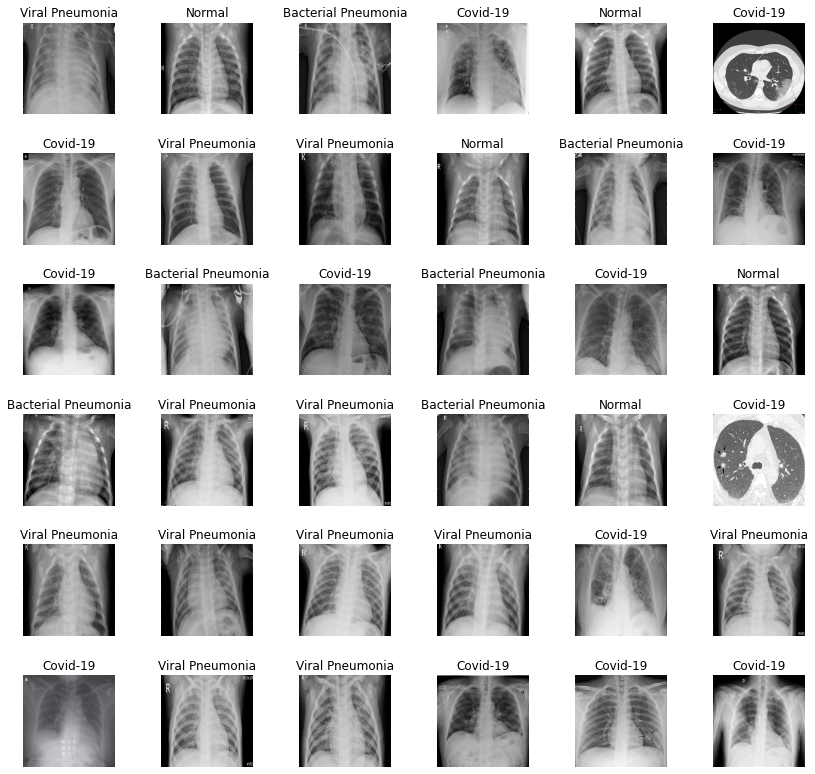

In [12]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (14, 14))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

In the following section, we will be using a pretrained model called ResNet50.

In [13]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

2023-01-02 19:27:40.303141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 19:27:40.405206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 19:27:40.406587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 19:27:40.409272: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step


In [14]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

We would like to train the last 10 layers ourselves. Thus, those last 10 layers will be frozen.

In [15]:
for layer in basemodel.layers[:-10]:
    layers.trainable = False

# Building and training the model

In [16]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

* Average pooling is in order to reduce the size of the images by averaging the values of 4*4(16) pixels and putting the result, in a single pixel, which will replace the 16 originally selected pixels.
* Usinng dropout, we try to improve the model in terms of being more generalized.

In [17]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In order to avoid the model from overfitting, we add the early stopping.

In [18]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [19]:
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [20]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [21]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 25, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-01-02 19:27:46.226423: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2023-01-02 19:27:56.818319: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


107/107 [==============================] - 33s 149ms/step - loss: 0.9294 - accuracy: 0.6308 - val_loss: 4.1091 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 4.10912, saving model to weights.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
107/107 [==============================] - 12s 105ms/step - loss: 0.4426 - accuracy: 0.8598 - val_loss: 23.8564 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 4.10912
Epoch 3/25
107/107 [==============================] - 12s 109ms/step - loss: 0.2184 - accuracy: 0.9276 - val_loss: 19.9661 - val_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 4.10912
Epoch 4/25
107/107 [==============================] - 12s 108ms/step - loss: 0.2868 - accuracy: 0.9346 - val_loss: 6.5371 - val_accuracy: 0.2596

Epoch 00004: val_loss did not improve from 4.10912
Epoch 5/25
107/107 [==============================] - 12s 112ms/step - loss: 0.1681 - accuracy: 0.9509 - val_loss: 16.7610 - val_accuracy: 0.3173

Epoch 00005: val_loss did not improve from 4.10912
Epoch 6/25
107/107 [==============================] - 12s 109ms/step - loss: 0.1325 - accuracy: 0.9556 - val_loss: 16.0383 - val_accuracy: 0.2500

Epoch 00006: val_loss did not improve from 4.10912
Epoch 7/25


# Evaluating the model

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

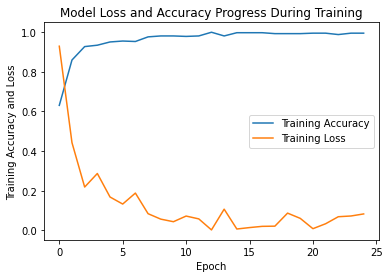

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

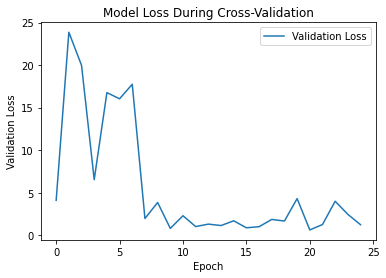

In [24]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

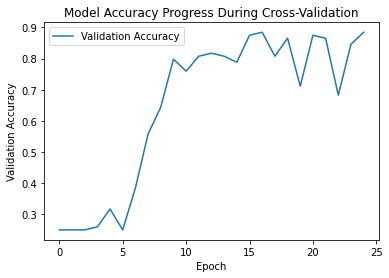

In [25]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [26]:
test_directory = '/kaggle/input/chest-xray-disease-images/Chest x-ray images/Test'

In [27]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


10/10 [==============================] - 1s 4ms/step - loss: 3.6264 - accuracy: 0.7750
Accuracy Test : 0.7749999761581421


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [29]:
len(original)

40

In [30]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.775


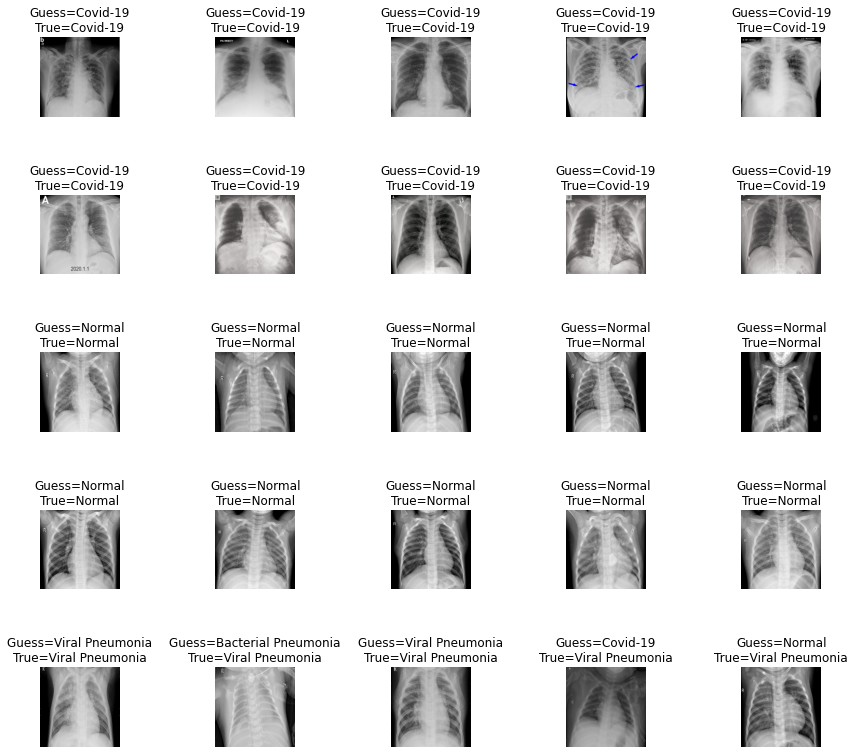

In [31]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (14, 14))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [32]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.67      1.00      0.80        10
           2       1.00      0.40      0.57        10
           3       0.88      0.70      0.78        10

    accuracy                           0.78        40
   macro avg       0.83      0.77      0.75        40
weighted avg       0.83      0.78      0.75        40



Text(0.5, 1.0, 'Confusion_matrix')

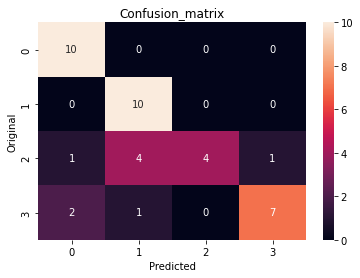

In [33]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')